In [2]:
import gensim
import numpy as np
import pandas as pd
import sys, time, os, warnings 
from collections import Counter 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import torchvision.models as models
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
# pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.1-cp36-cp36m-win_amd64.whl
# pip3 install torchvision


C:\Users\Pierre\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load Data

In [3]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "./Data/Flicker8k_Dataset/train/"
## The location of the caption file
dir_Flickr_text = "./data/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg files in Flicker8k: {}".format(len(jpgs)))

The number of jpg files in Flicker8k: 8091


In [4]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])


df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

Using TensorFlow backend.


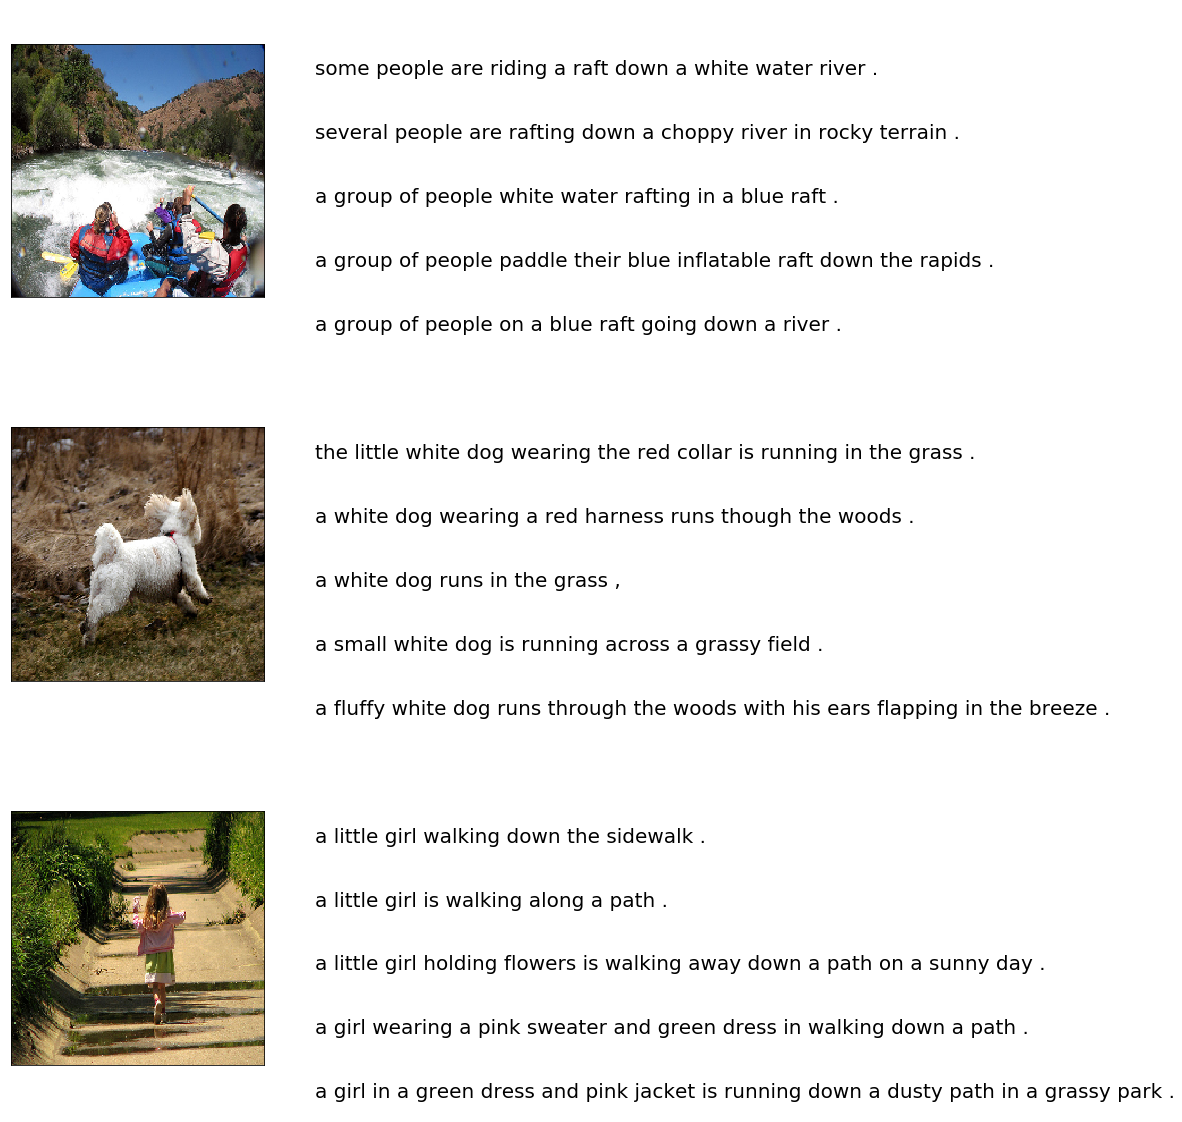

In [5]:
from keras.preprocessing.image import load_img, img_to_array

npix = 224
target_size = (npix,npix,3)

def get_random_pictures(n_pictures):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=n_pictures)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        image_load = load_img(filename, target_size=target_size)
        
        ax = fig.add_subplot(n_pictures,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(n_pictures,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
get_random_pictures(3)

# Sentence Processing 

In [7]:
def get_sentence_embedding(sentence, model):
    embeddings = np.array([model.word_vec(word) for word in sentence.split() if word in model.wv.vocab.keys()])
    return np.sum(embeddings.T,axis=1)

In [8]:
text_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300-SLIM.bin', binary=True)  

In [9]:
test = get_sentence_embedding('This is a test', text_model)

# Image Processing 

In [10]:
image_model = models.resnet18(pretrained=True)

In [11]:
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for param in image_model.parameters():
    param.requires_grad = False
image_model = image_model.to(device)

In [12]:
plt.ion()   # interactive mode

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = './Data/Flicker8k_Dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, ""),
                                          data_transforms[x])
                  for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}

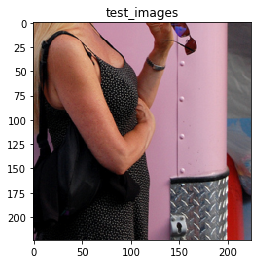

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="test_images")

In [13]:
for i, (inputs, labels) in enumerate(dataloaders['train']):
    inputs = inputs.to(device)
    print(inputs.shape)
    print(image_model(inputs).shape)
    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


In [188]:
def get_random_data(batch_size):
    for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=batch_size)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        random_caption = captions[np.random.randint(0,len(captions))]
        #image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB).T[np.newaxis, :]
        #image.swapaxes(2, 3)
        #print(image.shape)
        image, _ = next(iter(dataloaders['train']))
        image = image.numpy()
        return image_model(torch.from_numpy(image).type('torch.FloatTensor')), get_sentence_embedding(random_caption, text_model)

In [189]:
get_random_data(1)

(tensor([[-0.6811, -0.4788, -0.5196, -1.5892, -0.7444, -0.1918, -0.6559,  0.4710,
           0.2294, -0.7832, -1.0257, -0.9092, -0.4263, -1.1492, -1.1954, -0.6887,
          -0.9857, -0.4091, -0.6080, -0.7018, -1.7301, -0.6861, -1.3161,  0.1502,
          -0.9707, -1.2356, -0.9229, -1.1735, -0.9444, -0.4694, -0.8689, -0.8174,
          -0.4168, -0.5170, -0.3376, -0.5236,  0.5533, -0.6870, -0.4756,  0.0507,
          -0.8140, -0.8701, -1.1656, -0.5195, -0.7045, -0.4142, -0.8358, -0.4725,
          -1.2598, -1.1620, -0.4203,  0.5073, -0.4067, -0.7454, -0.2634, -1.1791,
          -0.4173, -1.6351, -0.7138, -0.5024,  0.6648,  0.0550, -0.1564, -0.0853,
          -0.7895, -0.2592, -0.3541, -0.4506, -0.8037, -0.9603, -1.6108,  0.0982,
          -1.4854, -0.3417, -1.1917, -1.4272, -0.0138, -0.6955,  0.1162,  0.0036,
          -0.8874, -1.6350, -0.1532, -0.7792, -0.5896, -0.1066, -0.0208,  0.3397,
          -0.0647, -0.6945, -1.1807, -1.2654, -1.9423, -0.4679,  0.0274, -2.1472,
          -0.587

In [98]:
batch_size = 1
for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=batch_size)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        random_caption = captions[np.random.randint(0,len(captions))]
        image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)[np.newaxis, :].swapaxes(2,3).swapaxes(1,2)
        print(image_model(torch.from_numpy(image).type('torch.FloatTensor')), get_sentence_embedding(random_caption, text_model))

RuntimeError: size mismatch, m1: [1 x 30720], m2: [512 x 1000] at c:\new-builder_3\win-wheel\pytorch\aten\src\th\generic/THTensorMath.cpp:2070

In [144]:
image.swapaxes(2,3).swapaxes(1,2).shape,image.shape

((1, 500, 3, 357), (1, 3, 357, 500))

In [145]:
image.shape

(1, 3, 357, 500)

In [39]:
image[0,:,:,:].shape

(333, 500, 3)

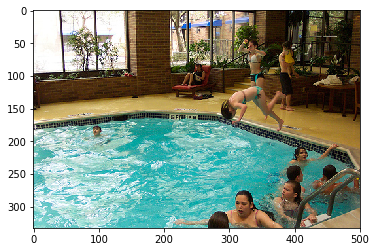

In [40]:
plt.imshow(image[0,:,:,:])

# Sparse Autoencoder


In [468]:
import torch.nn as nn
import torch.nn.functional as F

class SparseAutoencoder(nn.Module):
    def __init__(self, n_inp, n_hidden):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(n_inp, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_inp)

    def forward(self, x):
        encoded = F.relu(self.encoder(x)) # or sigmoid
        decoded = F.sigmoid(self.decoder(encoded))
        return encoded, decoded
    

In [469]:
# Model parameters
BATCH_SIZE = 5
N_INP = 1000 + 300 # Image representation + Word2Vec
N_HIDDEN = 1800
N_EPOCHS = 10
LEARNING_RATE = 1e-3

use_kl = False

# If using KL-divergence
BETA = 3 # Importance of the KL-divergence penalty term
RHO = 0.01 # Target sparsity

if use_kl :
    rho = torch.FloatTensor([RHO for _ in range(N_HIDDEN)]).unsqueeze(0)

# If using L1 regularization
LAMBDA = 1e-5 # L1 penalty term

In [470]:
auto_encoder = SparseAutoencoder(N_INP, N_HIDDEN)
optimizer = optim.Adam(auto_encoder.parameters(), lr=LEARNING_RATE)

In [471]:
def kl_divergence(p, q):
    '''
    args:
        2 tensors `p` and `q`
    returns:
        kl divergence between the softmax of `p` and `q`
    '''
    p = F.softmax(p)
    q = F.softmax(q)

    s1 = torch.sum(p * torch.log(p / q))
    s2 = torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))

    return s1 + s2

In [472]:
def l1_penalty(var):
    return torch.abs(var).sum()

In [473]:
images_train = torch.empty(BATCH_SIZE, 1000).uniform_(0, 1)
captions_train = torch.empty(BATCH_SIZE, 300).uniform_(0, 1)

print(images_train.shape)
print(captions_train.shape)

for epoch in range(N_EPOCHS):
    x = torch.cat((images_train, captions_train), 1)
    encoded, decoded = auto_encoder(x)

    #MSE_loss = (x - decoded) ** 2
    #MSE_loss = MSE_loss.sum() / (BATCH_SIZE*x.shape[1]) 
    #MSE_loss = MSE_loss.mean()
    
    mse_loss = F.mse_loss(decoded, x)

    rho_hat = torch.sum(encoded, dim=0, keepdim=True)/BATCH_SIZE
    
    if use_kl:
        sparsity_penalty = BETA * kl_divergence(rho, rho_hat)
        loss = mse_loss + sparsity_penalty
    else:
        l1_reg = LAMBDA * l1_penalty(encoded)
        loss = mse_loss + l1_reg
    
    optimizer.zero_grad() # Clears the gradient
    loss.backward() # Computes gradient
    optimizer.step() # Update rule

    print("Epoch: [%3d], Loss: %.4f" %(epoch + 1, loss.data))
    print("Average sparsity : ",  rho_hat.sum()/N_HIDDEN)


torch.Size([5, 1000])
torch.Size([5, 300])
Epoch: [  1], Loss: 0.0968
Average sparsity :  tensor(0.1362, grad_fn=<DivBackward0>)
Epoch: [  2], Loss: 0.0823
Average sparsity :  tensor(0.0247, grad_fn=<DivBackward0>)
Epoch: [  3], Loss: 0.0789
Average sparsity :  tensor(0.0256, grad_fn=<DivBackward0>)
Epoch: [  4], Loss: 0.0744
Average sparsity :  tensor(0.0417, grad_fn=<DivBackward0>)
Epoch: [  5], Loss: 0.0695
Average sparsity :  tensor(0.0619, grad_fn=<DivBackward0>)
Epoch: [  6], Loss: 0.0654
Average sparsity :  tensor(0.0769, grad_fn=<DivBackward0>)
Epoch: [  7], Loss: 0.0607
Average sparsity :  tensor(0.0790, grad_fn=<DivBackward0>)
Epoch: [  8], Loss: 0.0548
Average sparsity :  tensor(0.0721, grad_fn=<DivBackward0>)
Epoch: [  9], Loss: 0.0488
Average sparsity :  tensor(0.0635, grad_fn=<DivBackward0>)
Epoch: [ 10], Loss: 0.0428
Average sparsity :  tensor(0.0582, grad_fn=<DivBackward0>)


In [474]:
# Test
image_test = torch.empty(1, 1000).uniform_(0, 1)
caption_test = torch.empty(1, 300).uniform_(0, 1)

x = torch.cat((images_train, captions_train), 1)
encoded, decoded = auto_encoder(x)

print(x)
i=0
for e in encoded[0]:
    if e > 1e-3:
        print(e)
        i+=1
print(i, "elements different from 0")
print(torch.abs(x-decoded))
print(torch.sum(torch.abs(x-decoded)))

tensor([[0.4052, 0.3063, 0.8963,  ..., 0.6710, 0.8586, 0.5612],
        [0.8490, 0.3587, 0.9226,  ..., 0.3296, 0.0772, 0.6445],
        [0.0844, 0.2009, 0.0144,  ..., 0.5977, 0.1186, 0.9656],
        [0.7211, 0.6189, 0.8561,  ..., 0.6806, 0.5722, 0.5594],
        [0.2304, 0.1358, 0.5167,  ..., 0.9395, 0.4899, 0.8264]])
tensor(2.5821, grad_fn=<SelectBackward>)
tensor(0.1206, grad_fn=<SelectBackward>)
tensor(1.6633, grad_fn=<SelectBackward>)
tensor(2.7733, grad_fn=<SelectBackward>)
tensor(0.5866, grad_fn=<SelectBackward>)
tensor(1.6928, grad_fn=<SelectBackward>)
tensor(1.8893, grad_fn=<SelectBackward>)
tensor(1.8202, grad_fn=<SelectBackward>)
tensor(0.0722, grad_fn=<SelectBackward>)
tensor(2.1994, grad_fn=<SelectBackward>)
tensor(0.1831, grad_fn=<SelectBackward>)
tensor(0.3519, grad_fn=<SelectBackward>)
tensor(1.2245, grad_fn=<SelectBackward>)
tensor(1.2386, grad_fn=<SelectBackward>)
tensor(1.4475, grad_fn=<SelectBackward>)
tensor(1.2831, grad_fn=<SelectBackward>)
tensor(0.5151, grad_fn=

# Autoassociative memory - Hopfield Network

In [487]:
# Get autoencoder's hidden representations
x = torch.cat((images_train, captions_train), 1)
encoded, _ = auto_encoder(x)

In [488]:
def calculate_weights(learning_patterns):
    
    w = (np.transpose(learning_patterns) @ learning_patterns) / learning_patterns.shape[0]
    np.fill_diagonal(w, 0)
    
    return w

In [489]:
def energy(x, w):
    
    energy = 0
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            energy -= w[i, j]*x[i]*x[j]
            
    return energy

In [490]:
def update_rule_little_model(x, w):

    x = x @ w
    x = np.where(x>=0, 1, -1)

    return x

In [491]:
def recall(x, w):
    
    print("Initial energy : ", energy(x, w))
    x_new = update_rule_little_model(x, w)
    i = 0 # To stop if no convergence
    print("Energy : ", energy(x_new, w))
    while(np.array_equal(x_new, x) == False and i<10):
        x = x_new
        x_new = update_rule_little_model(x, w)
        print("Energy : ", energy(x_new, w))
        i+=1
        
    return x_new, i

In [492]:
encoded = encoded.detach().numpy()
print(encoded)
w = calculate_weights(learning_patterns=encoded)
x, _ = recall(encoded[0,:], w)
print(x.shape)
print(encoded[0,:])
print(x)
print(np.sum(np.abs(x-encoded[0,:])))

[[0.        2.582109  0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        2.0168772]
 [0.        0.        0.        ... 0.        0.        0.5452468]
 [0.        0.        0.        ... 0.        0.        1.2797718]]
Initial energy :  -11658.07746471572
Energy :  -59720838.50396307
Energy :  -407566646498.3489
Energy :  -2922451639883415.5
Energy :  -2.1104762545650115e+19
Energy :  -1.5256183028806516e+23
Energy :  -1.1029906414396934e+27
Energy :  -7.974551417733672e+30
Energy :  -5.76556528411247e+34
Energy :  -4.168479758838906e+38
Energy :  -inf
Energy :  -inf
(1800,)
[0.       2.582109 0.       ... 0.       0.       0.      ]
[0.0000000e+00 9.1231114e+20 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 1.2999470e+21]
1.7699972e+23
